# Udacity Behavior Cloning Project

In [1]:
# Keras model for cloning the driving behavior
# required libraries

%matplotlib inline
import matplotlib.pyplot as plt

import os
import argparse

import pandas as pd
import csv

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.regularizers import l2

# Custom library
from utils import *

/Users/Endymion/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/Endymion/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Endymion/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np

In [2]:
# Location of the driving log
data_dir = 'data/mydata_best_augmented/'
driving_log = data_dir +'driving_log.csv'

In [3]:
def import_data(driving_log):
    '''
    Create training and validation dataset
    from the driving log
    '''
    samples = []
    with open(driving_log) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            steering_center = float(line[3])
            # create adjusted steering measurements for the side camera images
            correction = 0.2 # this is a parameter to tune
            steering_left = steering_center + correction
            steering_right = steering_center - correction
            
            samples.append(line)
    
    # Set 20% of the entire dataset as validation
    test_split_ratio = 0.2
    train_samples, validation_samples = train_test_split(samples, test_size=test_split_ratio)
    
    return train_samples, validation_samples

In [4]:
# Visualize the cropped resized image
# train_samples,validation_samples = import_data(driving_log)
# img = load_image(train_samples[0][0])
# processed_img = preprocess_image(img)
# print(processed_img.shape)
# plt.imshow(processed_img)

In [5]:
def NVIDIA_end2end_learning_model(verbose=False):
    '''
    Keras model apoted from Nivida's End to End Learning for Self-Driving Cars paper
    URL: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    '''
    
    rows, cols, ch = 66, 200, 3
    nn_input_shape = ((rows, cols, ch))
    
    model = Sequential()
    
    # Normalization layer 3@66x200
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=nn_input_shape))
    
    # 3 layers of 5x5 convolution (output depth 24, 36, and 48) each with 2x2 stride
    model.add(Conv2D(24,kernel_size=5, strides=(2, 2), padding='valid', activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Conv2D(36,kernel_size=5, strides=(2, 2), padding='valid', activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Conv2D(48,kernel_size=5, strides=(2, 2), padding='valid', activation='relu',kernel_regularizer=l2(0.001)))
    
    # 2 layers of 3x3 convolution (output depth 64, and 64)
    
    model.add(Conv2D(64,kernel_size=3, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64,kernel_size=3, activation='relu',kernel_regularizer=l2(0.001)))
    
    # Flatten convolution layer
    model.add(Flatten())
    
    # 3 layers of fully connected (depth 100, 50, 10)
    model.add(Dense(100, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(50, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(10, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1))
    
    if verbose:
        # Show summary of the layers, output shapes and number of parameters
        model.summary()    

    return model

def batch_generator(samples, batch_size):
    '''
    The custom batch generator divide the data sample in batches and
    applies the image preprocessing (i.e. cropped,resize,RGB2YUV colorspace)
    '''
    
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # Randomly select one of the three camera positions (left, center, right)
                selected_img, steering_angle = random_camera(data_dir,batch_sample)
                selected_img, steering_angle = augument_data(selected_img, steering_angle)
                
                selected_img = preprocess_image(selected_img)
                images.append(selected_img)
                angles.append(steering_angle)

                # Center image and steering angle
                # name = data_dir+'IMG/'+batch_sample[0].split('/')[-1]
                # 
                # center_image = load_image(name)
                # center_image = preprocess_image(center_image)
                # center_angle = float(batch_sample[3])
                # 
                # images.append(center_image)
                # angles.append(center_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

def train_model(model,train_samples,validation_samples,save_model=True):
    '''
    Pipeline to feed the sample data (images and steering angles) in batches,
    train and save the Keras model
    '''
    
    '''
    verbose: Verbosity mode: 0, 1, or 2.
    0 = silent
    1 = progress bar
    2 = one line per epoch
    '''

    # Save the model weights after each epoch if the validation loss decreased
    checkpoint = ModelCheckpoint(filepath='checkpoint/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    
    # Early Stopping
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=2, 
    #               verbose=1, mode='auto', baseline=None, restore_best_weights=False)
    
    # Log the training progress
    # training log format: epoch, training loss, validation loss
    csv_logger = CSVLogger('log/training.log')

    batch_size = 64
    epochs = 10
    learning_rate = 1e-4
    
    # Compile the Keras model for training to predict the steering angles
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
    
    # Generate the "just in time" data in batches to feed to the model training pipeline
    # model.fit_generator()
    train_generator      = batch_generator(train_samples, batch_size=batch_size)
    validation_generator = batch_generator(validation_samples, batch_size=batch_size)
    
    # Train the model with the generated batched data
    training_history = model.fit_generator(train_generator,
                        steps_per_epoch = len(train_samples)//batch_size,
                        validation_data =  validation_generator,
                        validation_steps= len(validation_samples)//batch_size,
                        epochs=epochs, verbose=1,
                        max_queue_size=1,
                        callbacks=[checkpoint, csv_logger],
                        )

    # Save the Keras model for use to predict the steering angles later
    # with the drive.py
    if save_model:
       model.save('model.h5')
    
    return training_history

def plot_training_history(history_object):
    '''
    plot the training and validation loss for each epoch`
    
    '''
    
    print(history_object.history.keys())
    print(history_object.history)
    
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

Epoch 1/10
61/61 [==============================] - 23s 370ms/step - loss: 0.5149 - val_loss: 0.4772
Epoch 2/10
61/61 [==============================] - 23s 373ms/step - loss: 0.4346 - val_loss: 0.3956
Epoch 3/10
61/61 [==============================] - 23s 373ms/step - loss: 0.3677 - val_loss: 0.3459
Epoch 4/10
61/61 [==============================] - 23s 373ms/step - loss: 0.3260 - val_loss: 0.3133
Epoch 5/10
61/61 [==============================] - 23s 372ms/step - loss: 0.2936 - val_loss: 0.2821
Epoch 6/10
61/61 [==============================] - 23s 372ms/step - loss: 0.2682 - val_loss: 0.2561
Epoch 7/10
61/61 [==============================] - 22s 367ms/step - loss: 0.2453 - val_loss: 0.2413
Epoch 8/10
61/61 [==============================] - 23s 372ms/step - loss: 0.2274 - val_loss: 0.2265
Epoch 9/10
61/61 [==============================] - 23s 378ms/step - loss: 0.2117 - val_loss: 0.2106
Epoch 10/10
61/61 [==============================] - 23s 370ms/step - loss: 0.1985 - val_lo

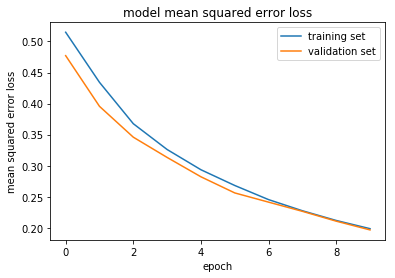

In [6]:
'''
Pipeline to import data from vehicle simulator, train the model
to predict the steering angle
'''

# Import the sample data collected from the Udacity vehicle simulator
train_samples,validation_samples = import_data(driving_log)

# Build the modified Nvidia Keras model
model = NVIDIA_end2end_learning_model()
# model = load_model('model.h5')

# Train the Keras model
history_object = train_model(model,train_samples,validation_samples)

# Diplay the training results
plot_training_history(history_object)